In [1]:
import cv2
import numpy as np
from PIL import Image
from matplotlib import pyplot as plt

In [2]:
srcPath = 'img/what.jpeg'

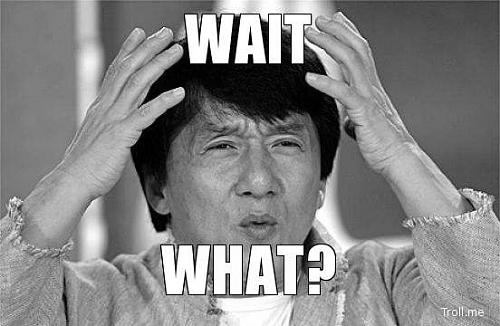

In [3]:
srcBgr = cv2.imread(srcPath)
gray = cv2.cvtColor(srcBgr, cv2.COLOR_BGR2GRAY)
#srcRgb = cv2.cvtColor(srcBgr, cv2.COLOR_BGR2RGB)
Image.fromarray(gray)

# Histogram of image

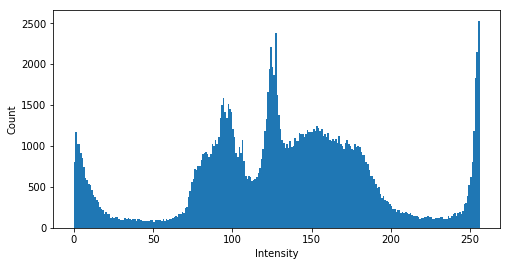

In [33]:
plt.figure(figsize=(8,4))
plt.hist(gray.ravel(),256,[0,256])
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.show()

### Normalization to [-1, 1]

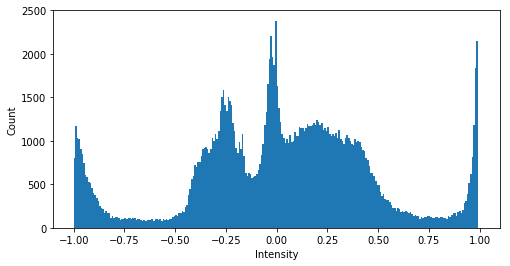

In [34]:
normGray = cv2.normalize(gray, None, alpha=-1, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
plt.figure(figsize=(8,4))
plt.hist(normGray.ravel(),256,[-1,1])
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.show()

### RMS(standard deviation)

In [6]:
np.std(normGray)

0.4681031

### Decrease image RMS

Make the mean intensity to be zero.
And then alter the standard deviation to be 0.2.

In [7]:
normStarndardNormGray = normGray - np.mean(normGray) 
np.mean(normStarndardNormGray)

8.986771e-09

In [8]:
# Alter the standard deviation to 1.
normStarndardNormGray = normStarndardNormGray / np.std(normStarndardNormGray)
np.std(normStarndardNormGray)

0.9999999

In [9]:
# Alter the standard deviation to 0.2.
normStarndardNormGray = normStarndardNormGray * 0.2
np.std(normStarndardNormGray)

0.2

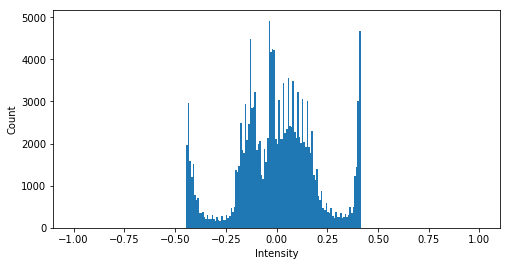

In [35]:
plt.figure(figsize=(8,4))
plt.hist(normStarndardNormGray.ravel(),256,[-1,1])
plt.xlabel('Intensity')
plt.ylabel('Count')
plt.show()

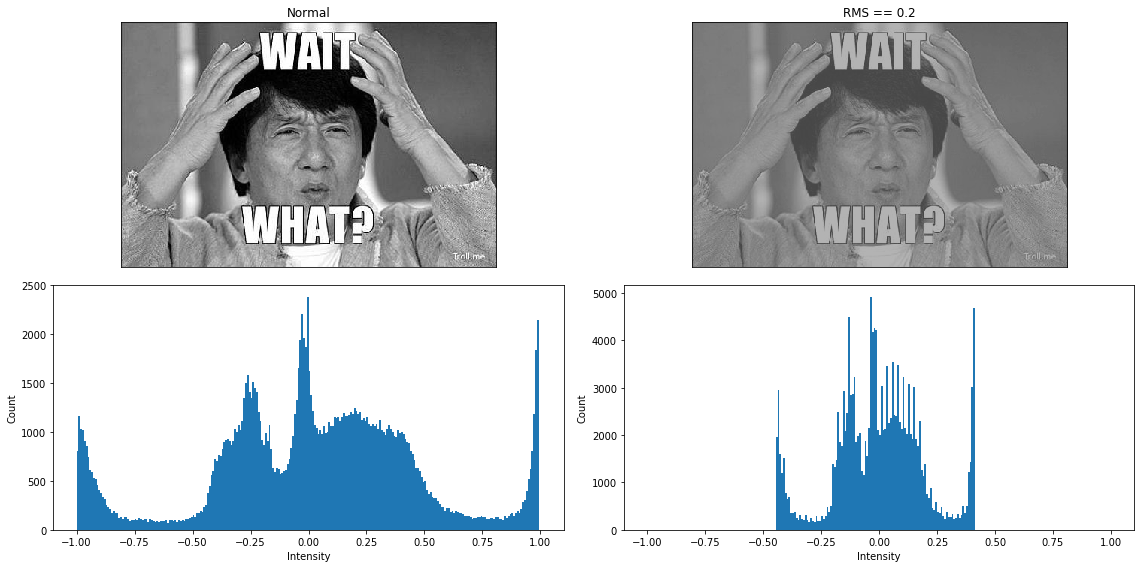

In [37]:
# plt.imshow は勝手にarrayを正規化するためmin,maxを設定
plt.figure(figsize=(16,8))
plt.subplot(2, 2, 1)
plt.imshow(normGray, cmap='gray', vmin = -1, vmax = 1)
plt.title('Normal')
plt.xticks([])
plt.yticks([])

plt.subplot(2, 2, 2)
plt.imshow(normStarndardNormGray, cmap='gray', vmin = -1, vmax = 1)
plt.title('RMS == 0.2')
plt.xticks([])
plt.yticks([])

plt.subplot(2, 2, 3)
plt.hist(normGray.ravel(),256,[-1,1])
plt.xlabel('Intensity')
plt.ylabel('Count')

plt.subplot(2, 2, 4)
plt.hist(normStarndardNormGray.ravel(),256,[-1,1])
plt.xlabel('Intensity')
plt.ylabel('Count')

plt.tight_layout()
plt.show()

####  Margin of Float type error
    
$ 0.00000000000000000000000001101101001 = 1.101101001 * 2^{-26} $

1.101101001 → 仮数    
-26 → 指数    
![float](img/float.png)

In [12]:
type(normGray[0,0])

numpy.float32

In [13]:
# Accuracy
2**23

8388608

# Fourier Transform

In [14]:
from scipy import signal

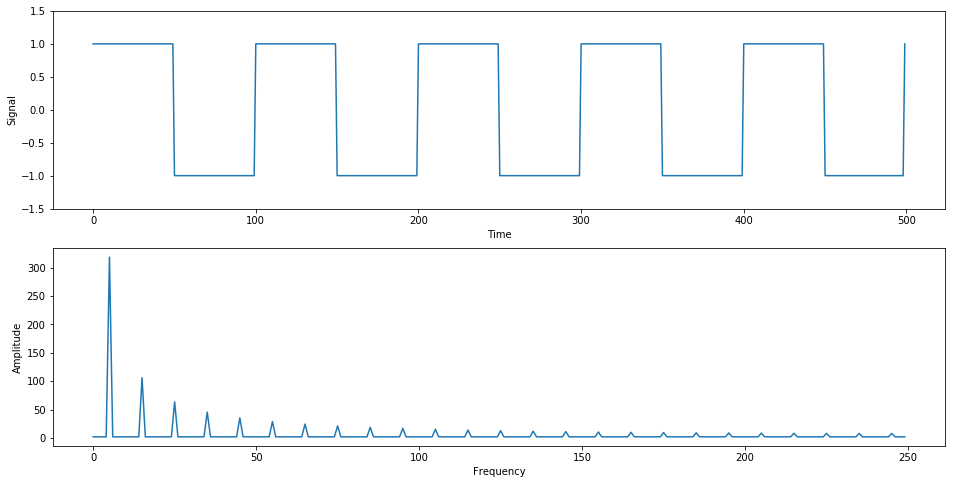

In [38]:
# origin signal
p = 2 * np.pi # period
dataSample = 500
t = np.linspace(0, p * 5, dataSample) # display 5 period
s = signal.square(t) # signal

plt.figure(figsize=(16,8))
plt.subplot(2,1,1)
plt.plot(s)
plt.ylim(-1.5, 1.5)
plt.xlabel('Time')
plt.ylabel('Signal')

# fourier transform
fftRes = abs(np.fft.fft(s))
plt.subplot(2,1,2)
plt.plot(fftRes[:dataSample//2])
plt.xlabel('Frequency')
plt.ylabel('Amplitude')

plt.show()

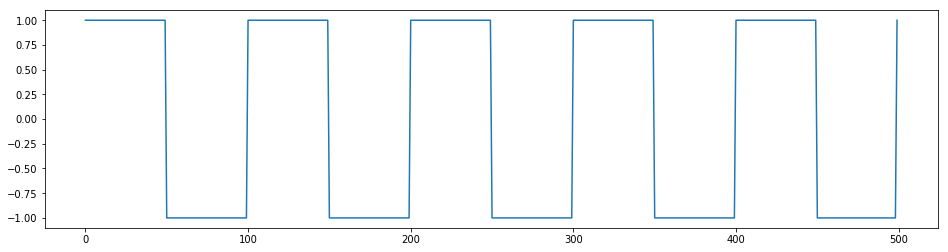

In [39]:
# TODO: FFT IFFT
ifftRes = np.fft.ifft(np.fft.fft(s))
plt.figure(figsize=(16,4))
plt.plot(ifftRes.real)

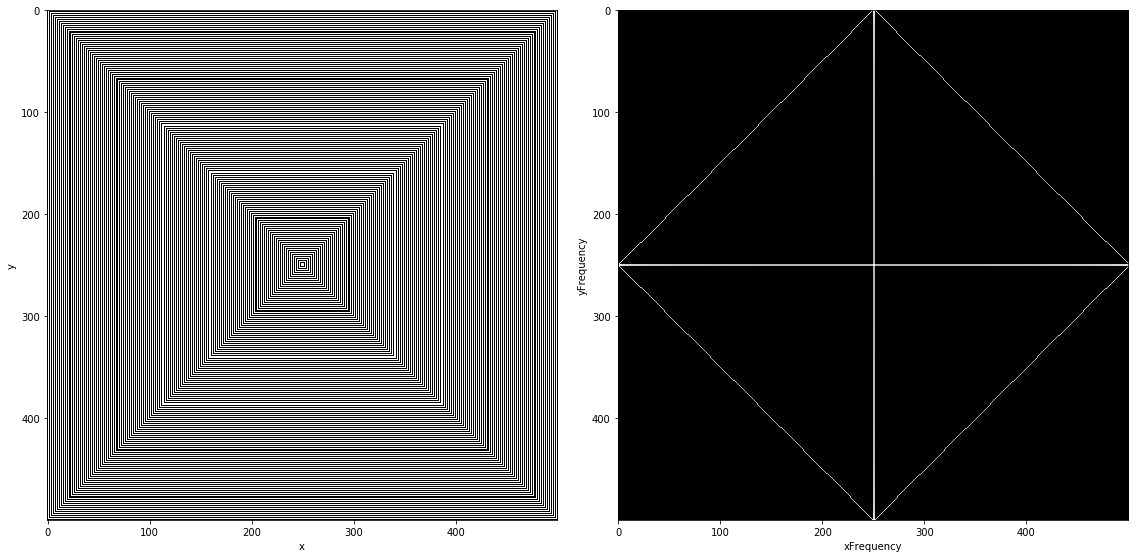

In [102]:
# origin signal
lineSize = 1
imgSize = 500

s = np.zeros([imgSize, imgSize])
for i in range(imgSize//lineSize):
    color = i % 2
    s[i*lineSize: imgSize-i*lineSize, i*lineSize: imgSize-i*lineSize] = color
# for i in range(imgSize//lineSize):
#     color = i % 2
#     s[i*lineSize:,:] = color

plt.figure(figsize=(16,8))

plt.subplot(1,2,1)
plt.imshow(s, cmap='gray')
plt.xlabel('x')
plt.ylabel('y')

fftS = np.fft.fftshift(np.fft.fft2(s))
plt.subplot(1,2,2)
fftSDisp = np.log(abs(fftS) + 0.0001)
fftSDisp = cv2.normalize(fftSDisp, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
plt.imshow(fftSDisp, cmap='gray')
plt.xlabel('xFrequency')
plt.ylabel('yFrequency')

plt.tight_layout()
plt.show()

# Converting to frequency space

Fast Fourier Transform

2次元ユークリッド空間の直交座標系画像を極座標系に変換(フーリエ変換)

http://www.clg.niigata-u.ac.jp/~medimg/practice_medical_imaging/imgproc_scion/5fourier/index.htm

In [18]:
# convert to frequency domain
normGrayFft = np.fft.fft2(normGray)
normGrayFftShift = np.fft.fftshift(normGrayFft)

# 表示のため
# calculate amplitude spectrum
# 第1象限と第3象限、第1象限と第4象限を入れ替え
grayShift = np.fft.fftshift(np.abs(normGrayFft))
grayShiftDisp = np.log(grayShift + 0.0001)
normGrayShiftDisp = cv2.normalize(grayShiftDisp, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

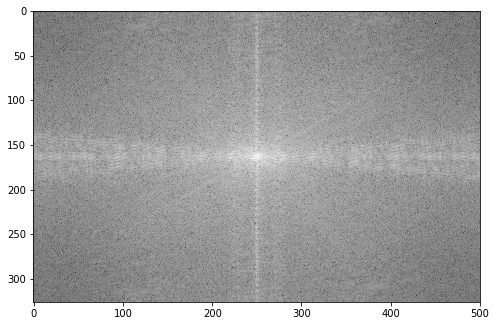

In [42]:
plt.figure(figsize=(8,6))
plt.imshow(normGrayShiftDisp, cmap='gray', vmin = 0, vmax = 1)

## Low-pass filter

高周波を除く

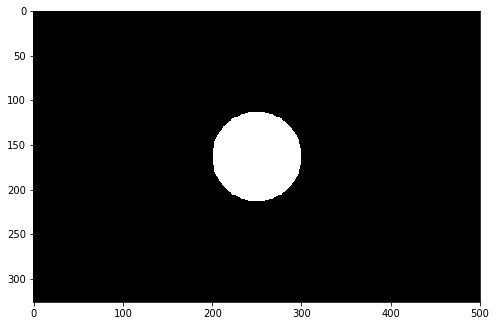

In [43]:
srcSize = gray.shape
center = (srcSize[0]//2,srcSize[1]//2)
# initializer filter
lpFilter = np.zeros(srcSize)
filterRadius = 50

for x in range(0,srcSize[0]):
    for y in range(0,srcSize[1]):
        if(x-center[0])**2 + (y-center[1])**2 < filterRadius**2:
            lpFilter[x,y] = 1

plt.figure(figsize=(8,6))
plt.imshow(lpFilter, cmap='gray', vmin = 0, vmax = 1)

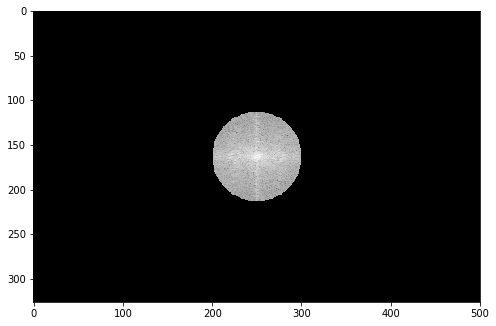

In [44]:
lpRes = normGrayFftShift*lpFilter

# 表示のため
plt.figure(figsize=(8,6))
plt.imshow(normGrayShiftDisp*lpFilter, cmap='gray', vmin = 0, vmax = 1)

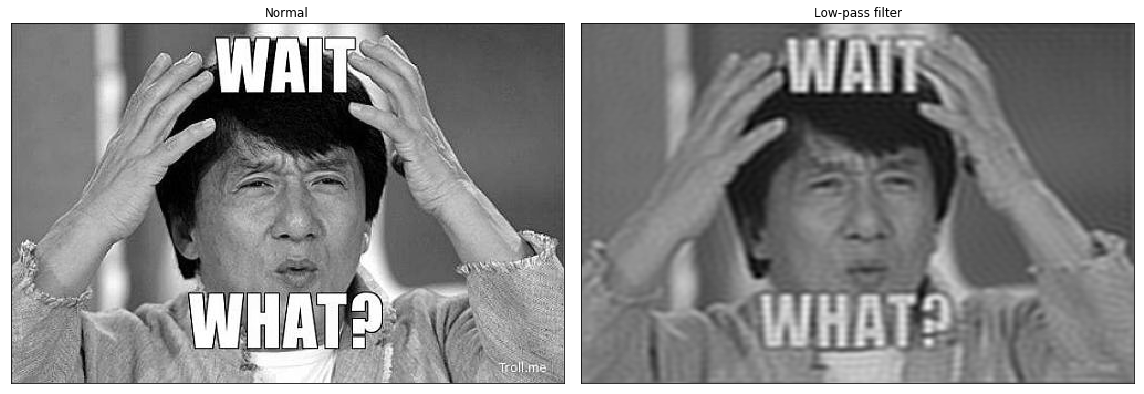

In [45]:
# Inverse Fourier Transform
grayConvert = np.real(np.fft.ifft2(np.fft.ifftshift(lpRes)))
normGrayConvertLp = cv2.normalize(grayConvert, None, alpha=-1, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.imshow(normGray, cmap='gray', vmin = -1, vmax = 1)
plt.title('Normal')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(normGrayConvertLp, cmap='gray', vmin = -1, vmax = 1)
plt.title('Low-pass filter')
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()

## High-pass filter

低周波を除く

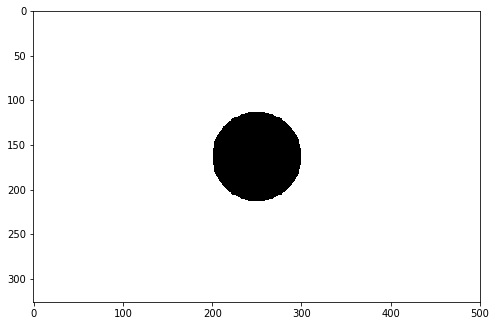

In [46]:
srcSize = gray.shape
center = (srcSize[0]//2,srcSize[1]//2)
# initializer filter
hpFilter = np.ones(srcSize)
filterRadius = 50

for x in range(0,srcSize[0]):
    for y in range(0,srcSize[1]):
        if(x-center[0])**2 + (y-center[1])**2 < filterRadius**2:
            hpFilter[x,y] = 0

plt.figure(figsize=(8,6))            
plt.imshow(hpFilter, cmap='gray', vmin = 0, vmax = 1)

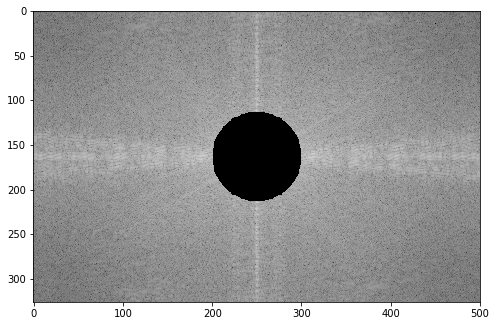

In [47]:
hpRes = normGrayFftShift*hpFilter

# 表示のため
plt.figure(figsize=(8,6))
plt.imshow(normGrayShiftDisp*hpFilter, cmap='gray', vmin = 0, vmax = 1)

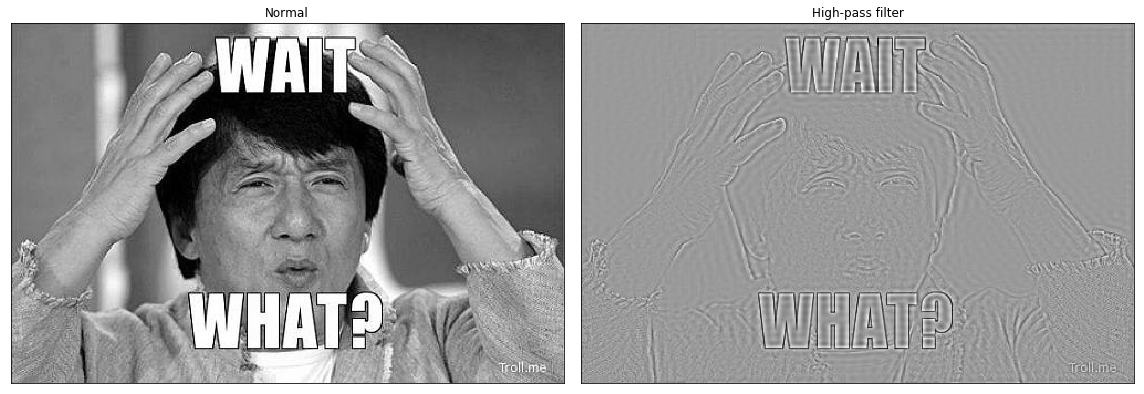

In [48]:
# Inverse Fourier Transform
grayConvert = np.real(np.fft.ifft2(np.fft.ifftshift(hpRes)))
normGrayConvertHp = cv2.normalize(grayConvert, None, alpha=-1, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)

plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.imshow(normGray, cmap='gray', vmin = -1, vmax = 1)
plt.title('Normal')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 2, 2)
plt.imshow(normGrayConvertHp, cmap='gray', vmin = -1, vmax = 1)
plt.title('High-pass filter')
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()

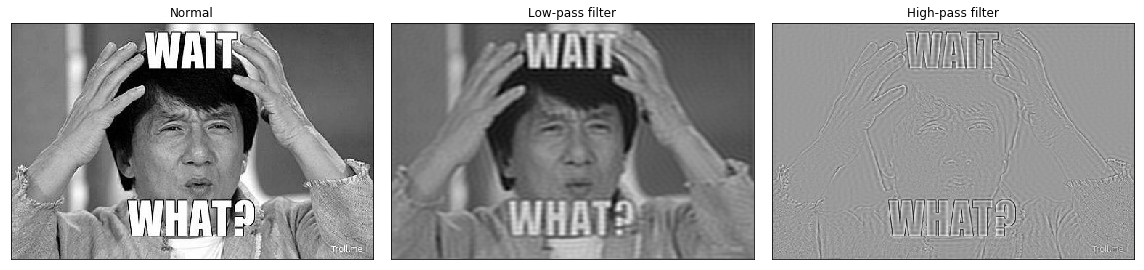

In [49]:
plt.figure(figsize=(16,8))
plt.subplot(1, 3, 1)
plt.imshow(normGray, cmap='gray', vmin = -1, vmax = 1)
plt.title('Normal')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 2)
plt.imshow(normGrayConvertLp, cmap='gray', vmin = -1, vmax = 1)
plt.title('Low-pass filter')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 3)
plt.imshow(normGrayConvertHp, cmap='gray', vmin = -1, vmax = 1)
plt.title('High-pass filter')
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()

# Spatial Frequency Fusion

In [204]:
imgShape = (400, 400)
highSrc = cv2.imread('img/abe.jpg', cv2.IMREAD_GRAYSCALE)
lowSrc = cv2.imread('img/trump.jpg', cv2.IMREAD_GRAYSCALE)
highSrc = cv2.resize(highSrc,imgShape)
lowSrc = cv2.resize(lowSrc,imgShape)

Text(0.5, 1.0, 'low-pass')

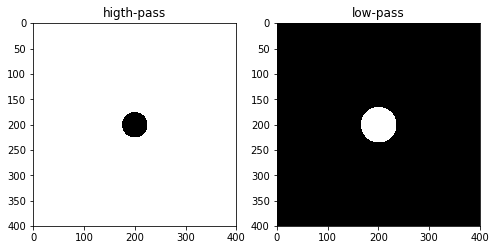

In [213]:
center = (imgShape[0]//2,imgShape[1]//2)
# initializer filter
hpFilter = np.ones(imgShape)
lpFilter = np.zeros(imgShape)
hpFilterRadius = 25
lpFilterRadius = 35

for x in range(0,imgShape[0]):
    for y in range(0,imgShape[1]):
        if(x-center[0])**2 + (y-center[1])**2 < hpFilterRadius**2:
            hpFilter[x,y] = 0
        if(x-center[0])**2 + (y-center[1])**2 < lpFilterRadius**2:
            lpFilter[x,y] = 1

plt.figure(figsize=(8,6))
plt.subplot(1,2,1)
plt.imshow(hpFilter, cmap='gray', vmin = 0, vmax = 1)
plt.title('higth-pass')

plt.subplot(1,2,2)
plt.imshow(lpFilter, cmap='gray', vmin = 0, vmax = 1)
plt.title('low-pass')

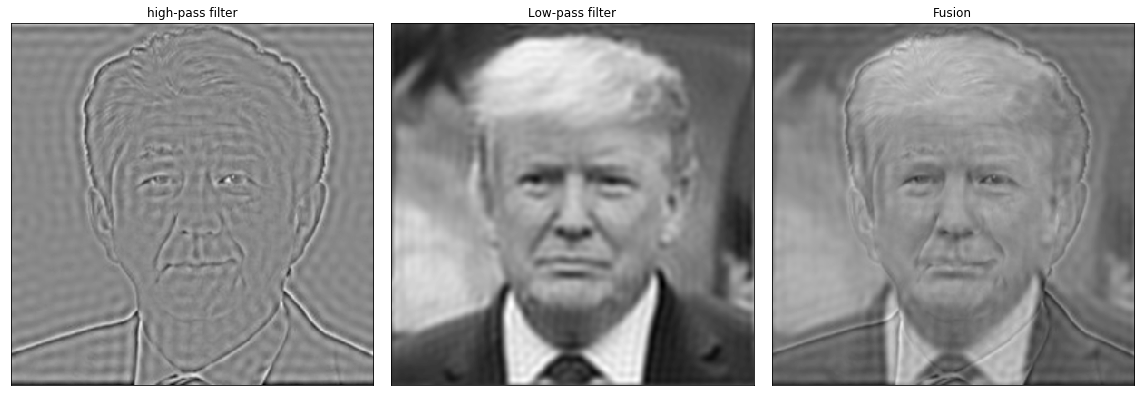

In [214]:
# Fourier Transform
fftHigh = np.fft.fftshift(np.fft.fft2(highSrc))
fftLow = np.fft.fftshift(np.fft.fft2(lowSrc))

# Inverse Fourier Transform
ifftHigh = cv2.normalize(
    np.real(np.fft.ifft2(np.fft.ifftshift(fftHigh * hpFilter))),
    None,
    alpha=-1,
    beta=1,
    norm_type=cv2.NORM_MINMAX,
    dtype=cv2.CV_32F
)
ifftLow = cv2.normalize(
    np.real(np.fft.ifft2(np.fft.ifftshift(fftLow * lpFilter))),
    None,
    alpha=-1,
    beta=1,
    norm_type=cv2.NORM_MINMAX,
    dtype=cv2.CV_32F
)

plt.figure(figsize=(16,8))
plt.subplot(1, 3, 1)
plt.imshow(ifftHigh, cmap='gray', vmin = -1, vmax = 1)
plt.title('high-pass filter')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 2)
plt.imshow(ifftLow, cmap='gray', vmin = -1, vmax = 1)
plt.title('Low-pass filter')
plt.xticks([])
plt.yticks([])

plt.subplot(1, 3, 3)
plt.imshow(ifftHigh + ifftLow, cmap='gray', vmin = -2, vmax = 2)
plt.title('Fusion')
plt.xticks([])
plt.yticks([])

plt.tight_layout()
plt.show()